### Packages loading

In [125]:
import sys
sys.path.insert(0, '..')
import matplotlib.pyplot as plt
import qiskit
import numpy as np
from qsee.compilation.qcompilation import QuantumCompilation
from qsee.core import ansatz, state
from qsee.backend import constant
from qsee.evolution import environment, crossover, mutate, selection
%load_ext autoreload
%autoreload 2


The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [126]:
num_qubits = 4
num_layers = 1
optimizer = 'adam'
compiler = QuantumCompilation(
    u = ansatz.g2gn(num_qubits, num_layers),
    vdagger = state.ame(num_qubits),
    optimizer = optimizer,
    loss_func = 'loss_basic'
)
compiler.fit(num_steps = 100, verbose = 2)

Step 0: 0.9327450364263308
Step 10: 0.031010070561982905
Step 20: 0.0034271868963537955
Step 30: 0.0007835916221182737
Step 40: 6.769366125736198e-05
Step 50: 1.8730935995581177e-06
Step 60: 6.688205603788688e-07
Step 70: 9.482079499356644e-08
Step 80: 1.685037420706692e-08
Step 90: 1.6972305783014008e-09


## 1. Quantum architecture search for quantum state preparation problem

This is state preparation circuit which is generated by classical method (amplitude encoding)

Now, we defind the problem which is need to solve

In [1]:
num_qubits = 5
if num_qubits == 2:
    qc_haar = state.specific(num_qubits,
    [ 0.73042448, -0.30956267, -0.45658101,  0.40272176])

def compilation_fitness_w(qc: qiskit.QuantumCircuit, num_steps=10):
    compiler = QuantumCompilation(
        u=qc,
        vdagger=state.w(num_qubits).inverse()
    )
    compiler.fit(num_steps=num_steps)
    return 1 - np.min(compiler.loss_values)

def compilation_fitness_ghz(qc: qiskit.QuantumCircuit, num_steps=5):
    compiler = QuantumCompilation(
        u=qc,
        vdagger=state.ghz(num_qubits).inverse()
    )
    compiler.fit(num_steps=num_steps)
    return 1 - np.average(compiler.loss_values)

def compilation_fitness(qc: qiskit.QuantumCircuit, num_steps=5):
    compiler = QuantumCompilation(
        u=qc,
        vdagger=qc_haar.inverse()
    )
    compiler.fit(num_steps=num_steps, verbose=0)
    return 1 - np.average(compiler.loss_values)


def compilation_threshold(fitness_value):
    if fitness_value < 0.1:
        return True
    return False


NameError: name 'qiskit' is not defined

Main algorithm, includes: init population, selection, crossover, mutate.

In [113]:
params = {'depth': 10,
          'num_circuit': 16,  # Must mod 8 = 0
          'num_generation': 10,
          'num_qubits': num_qubits,
          'threshold': compilation_threshold,
          'prob_mutate': 0.1}

env = environment.EEnvironment(
    params,
    fitness_func=compilation_fitness_w,
    selection_func=selection.elitist_selection,
    crossover_func=crossover.onepoint_crossover,
    mutate_func=mutate.bitflip_mutate,
    pool=constant.operations,
    file_name='../experiments/evolution/'
)

env.evol()

Initialize population ...
Start evol progress ...
Evol at generation 0
Cross-over
                     ┌───┐                ┌──────────────┐                »
q_0: ────────────────┤ X ├───────■────────┤ Rx(theta[5]) ├────────────────»
     ┌──────────────┐└─┬─┘       │        ├──────────────┤     ┌───┐      »
q_1: ┤ Ry(theta[0]) ├──┼─────────┼────────┤ Rx(theta[4]) ├─────┤ H ├──────»
     ├──────────────┤  │  ┌──────┴───────┐├──────────────┤┌────┴───┴─────┐»
q_2: ┤ Rx(theta[1]) ├──┼──┤ Ry(theta[3]) ├┤ Rx(theta[8]) ├┤ Ry(theta[9]) ├»
     ├──────────────┤  │  └────┬───┬─────┘├──────────────┤└──────┬───────┘»
q_3: ┤ Rz(theta[2]) ├──┼───────┤ H ├──────┤ Ry(theta[7]) ├───────┼────────»
     └──────────────┘  │       ├───┤      ├──────────────┤       │        »
q_4: ──────────────────■───────┤ H ├──────┤ Ry(theta[6]) ├───────■────────»
                               └───┘      └──────────────┘                »
«     ┌───────────────┐┌───────────────┐┌───────────────┐┌───────────────┐»
«q_0: 

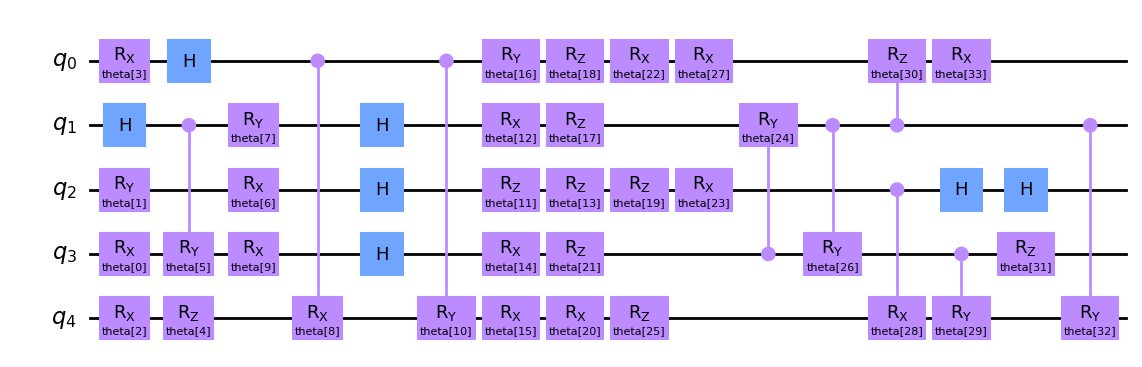

In [122]:
env.populations[2][0].qc.draw('mpl')

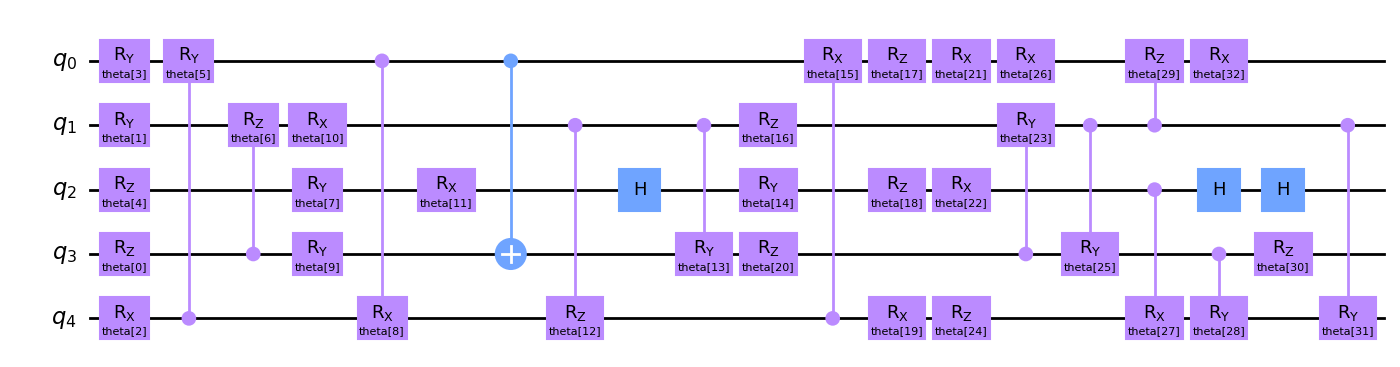

In [123]:
env.populations[2][1].qc.draw('mpl')

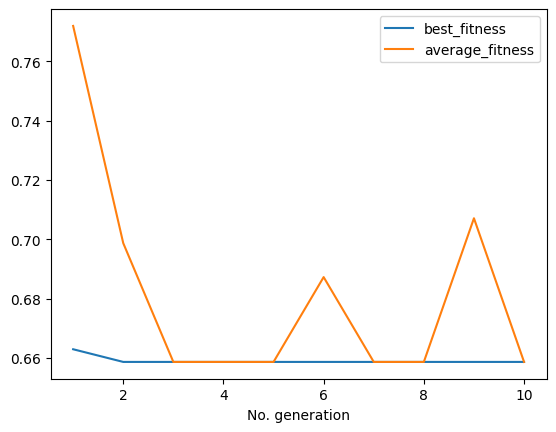

In [100]:
env.plot()

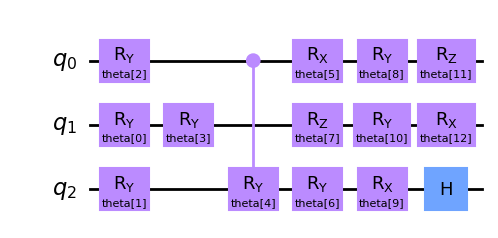

In [99]:
env.best_candidate.qc.draw('mpl')

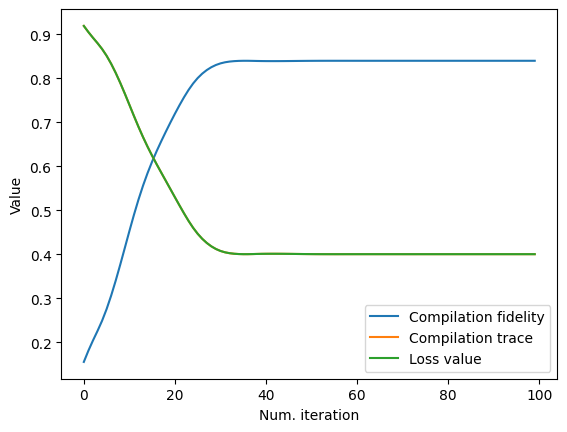

In [64]:
compiler = QuantumCompilation(
        u=env.best_candidate.qc,
        vdagger=state.w(num_qubits).inverse(),
        optimizer='adam',
        loss_func='loss_fubini_study'
    )
compiler.fit(num_steps=100, verbose=0)
compiler.plot(metrics = ['compilation'])

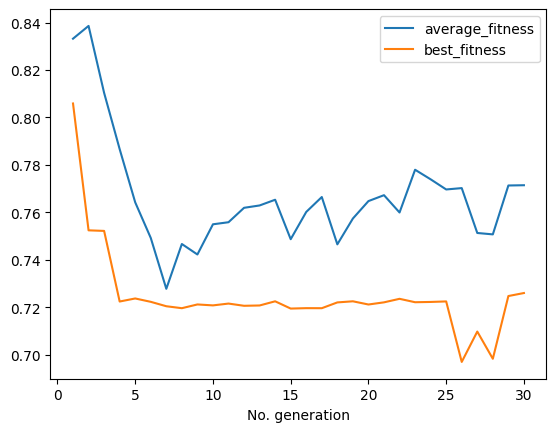

In [127]:
env.plot(metrics = ['average_fitness', 'best_fitness'])

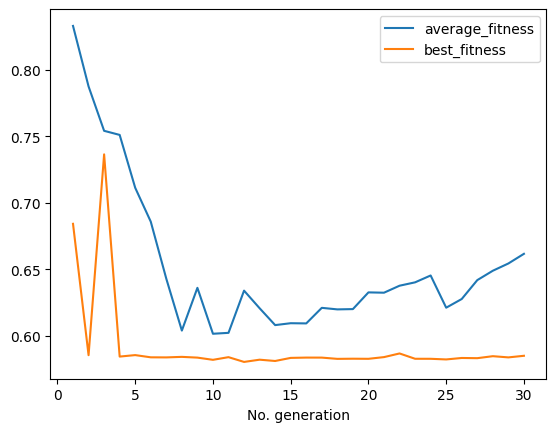

In [115]:
env.plot(metrics = ['average_fitness', 'best_fitness'])

In [132]:
x = [3.9375, 1.5000, 0.3125]
x = x / np.linalg.norm(x)
print(x)

[0.93192819 0.35502026 0.07396255]


In [133]:
0.93192819**2 + 0.35502026**2

0.9945295363271438

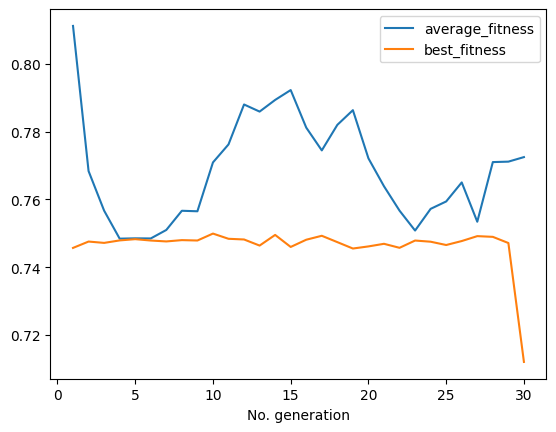

In [109]:
env.plot(metrics = ['average_fitness', 'best_fitness'])

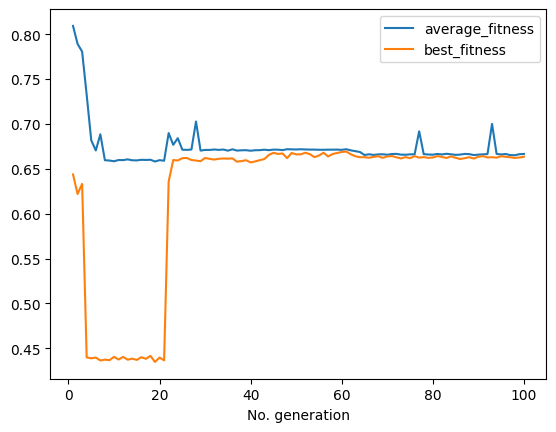

In [8]:
env2.plot(metrics = ['average_fitness', 'best_fitness'])

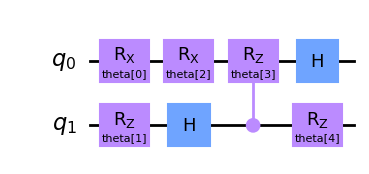

In [29]:
env.best_candidate.qc.draw('mpl')

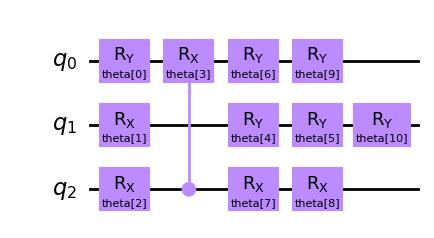

In [184]:
env2.populations[-1][7].qc.draw('mpl')

In [60]:
env2 = environment.EEnvironment('../experiments/evolution/ga_3qubits_4depths_compilation_fitness_2023-10-09.envobj')

Step:   0%|          | 0/10 [10:10:18<?, ?it/s]

Test best candidate again

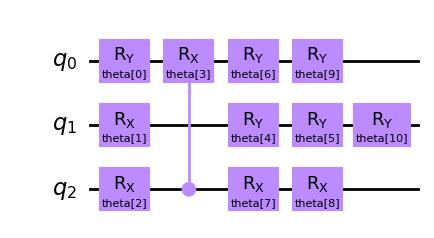

In [61]:
env2.best_candidate.qc.draw('mpl')

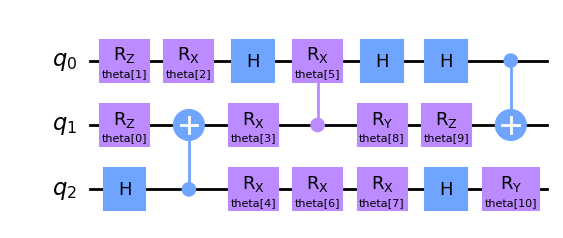

In [99]:
env.best_candidate.qc.draw('mpl')

In [100]:
qc = env.best_candidate.qc
compiler = qsee.qcompilation.QuantumCompilation(
    u=qc,
    vdagger=qsee.state.create_w_state(num_qubits).inverse(),
    optimizer='adam',
    loss_func='loss_fubini_study'
)
compiler.fit(num_steps=100, verbose=1)


Step: 100%|██████████| 100/100 [00:28<00:00,  3.46it/s]


In [ ]:
qsee.ansatz.Wchain_ZXZlayer_ansatz(3, 1).depth()


10

In [103]:
compiler2 = qsee.qcompilation.QuantumCompilation(
    # u = random_circuit.random_circuit(3, 10),
    # vdagger = qsee.state.create_w_state(qc.num_qubits).inverse(),
    u=qsee.ansatz.Wchain_ZXZlayer_ansatz(num_qubits, 1),
    vdagger=qsee.state.create_haar_state(num_qubits).inverse(),
    optimizer='adam',
    loss_func='loss_fubini_study'
)
compiler2.fit(num_steps=100, verbose=1)









Step:   0%|          | 0/100 [00:29<?, ?it/s]






























































































Step: 100%|██████████| 100/100 [01:21<00:00,  1.22it/s]


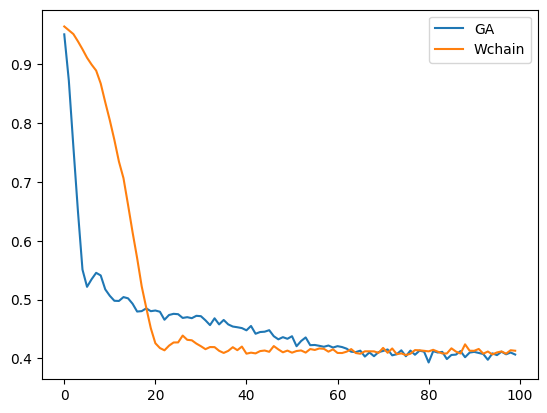

In [104]:
plt.plot(compiler.loss_values, label='GA')
plt.plot(compiler2.loss_values, label='Wchain')
plt.legend()